# 환경 설정, 라이브러리 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("=" * 60)
print("환경 설정 및 라이브러리 설치")
print("=" * 60)

!pip install ultralytics pycocotools tqdm -q

import os
import json
import glob
import shutil
import random
import zipfile
from pathlib import Path
from tqdm import tqdm
import torch
from ultralytics import YOLO

print("✅ 라이브러리 설치 완료")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

환경 설정 및 라이브러리 설치
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ 라이브러리 설치 완료
PyTorch 버전: 2.8.0+cu126
CUDA 사용 가능: True


# 경로 설정

In [ ]:
yaml_base = ###yaml 파일 경로

dataset_root = ##데이터셋 경로

test_images_folder = f'{dataset_root}images/test'
test_images = glob.glob(os.path.join(test_images_folder, '*.jpg'))

test_labels_folder = f'{dataset_root}labels/test'

In [ ]:
# 클래스 정의 (데이터에 맞게 수정)
class_name_to_number = {
    'ConcreteCrack': '0',
    'Spalling': '1',
    'Efflorescene': '2',
    'Leak': '3',
    'Exposure': '4',
    'AspaltCrack': '5',
    'Pothole': '6',
    'SteelDamage': '7'
}

# 학습 설정

In [ ]:
print("\n" + "=" * 60)
print("학습 설정")
print("=" * 60)

from argparse import Namespace

args = Namespace(
    epoch=100,
    project="yolo11n+sam",
    name="experiment",
    config=yaml_base,
    cuda="0",
    resume=False,
    resume_path=""
)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda
os.environ["WANDB_MODE"] = "disabled"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ 디바이스: {device}")
print(f"✅ Epochs: {args.epoch}")
print(f"✅ 프로젝트: {args.project}/{args.name}")

# 8. YOLO11 모델 학습

In [ ]:
# T4 기준, 15분 내외로 학습 소요
print("\n" + "=" * 60)
print("8️⃣ YOLO11 모델 학습")
print("=" * 60)

import glob, os

# dataset_root는 네 코드에서 이미 정의되어 있음
for cache_file in glob.glob(f"{dataset_root}/**/*.cache", recursive=True):
    print(f"🗑 삭제: {cache_file}")
    os.remove(cache_file)

########################################
# 사용 모델 설정
MODEL = "yolo11s.pt"
########################################



if args.resume and os.path.exists(args.resume_path):
    print(f"🔄 체크포인트 재개: {args.resume_path}")
    model = YOLO(args.resume_path)
else:
    print(f"🆕 새 모델 로드: {MODEL}")
    model = YOLO(MODEL)

model.to(device)


print(f"\n🚀 학습 시작...")
results = model.train(
    project=args.project,
    name=args.name,
    data=args.config,
    epochs=args.epoch,
    imgsz=512,
    batch=32,        ####### batch 설정
    device=device,
    optimizer="auto",
    val=True,
    resume=args.resume,
    verbose=True,
    patience=100,
    save=True,
    plots=True,
)

print(f"\n✅ 학습 완료!")
print(f"📁 결과: {args.project}/{args.name}/")


8️⃣ YOLO11 모델 학습
🆕 새 모델 로드: yolo11n.pt

🚀 학습 시작...
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=experiment, nbs=64, nms=False,

# 9. 최적 모델 검증

In [ ]:
print("\n" + "=" * 60)
print("9️⃣ 최적 모델 검증")
print("=" * 60)

best_model_path = f"{args.project}/{args.name}/weights/best.pt"

if os.path.exists(best_model_path):
    print(f"📦 최적 모델 로드: {best_model_path}")
    best_model = YOLO(best_model_path)

    print("\n📊 검증 세트 평가...")
    val_results = best_model.val(
        data=args.config,
        split='val',
        imgsz=512,
        batch=32,        ### validation batch 설정
        device=device,
    )

    print("\n✅ 검증 완료!")
    print(f"   - Box mAP50:     {val_results.box.map50:.4f}")
    print(f"   - Box mAP50-95:  {val_results.box.map:.4f}")
else:
    print(f"⚠️  최적 모델을 찾을 수 없음: {best_model_path}")


9️⃣ 최적 모델 검증
📦 최적 모델 로드: yolo11n+sam/experiment/weights/best.pt

📊 검증 세트 평가...
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 81.9±39.0 MB/s, size: 117.0 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1IPs_mayLrs6JdvAyiApMRJNmjycZDbtN/AICV_proj2/교량외관점검데이터/RESULT/datasets/labels/val.cache... 897 images, 126 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 897/897 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 29/29 5.0it/s 5.7s
                   all        897       2276      0.503      0.498      0.484      0.304
         ConcreteCrack        116        355      0.422      0.146      0.187     0.0701
              Spalling         55         92      0.411      0.478      0.432      0.258
          Efflorescene        113       

# 학습 결과 요약

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os


1️⃣2️⃣ 학습 결과 요약


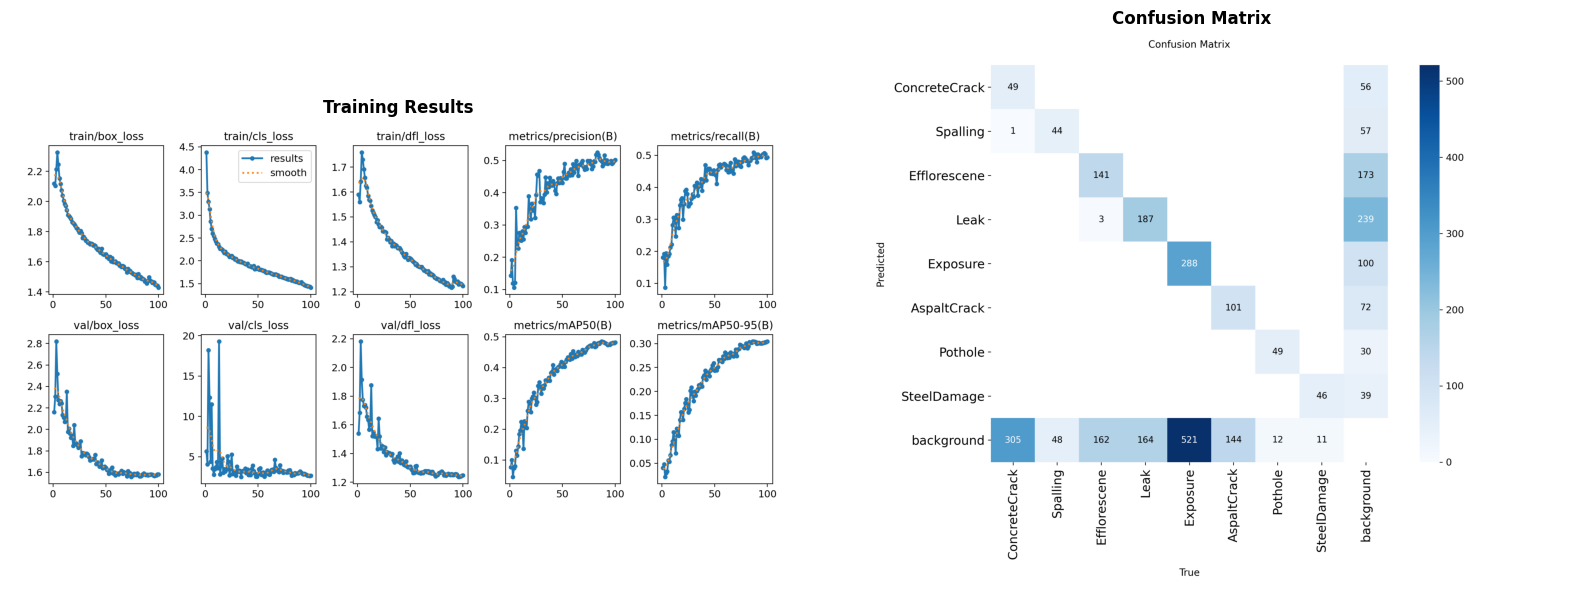

✅ 학습 요약: yolo11n+sam/experiment/training_summary.png

🎉 모든 작업 완료!

📂 주요 결과물:
   1. 데이터셋: /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets//
   2. 최적 모델: yolo11n+sam/experiment/weights/best.pt
   3. 학습 결과: yolo11n+sam/experiment/


NameError: name 'output_folder' is not defined

In [ ]:
print("\n" + "=" * 60)
print("1️⃣2️⃣ 학습 결과 요약")
print("=" * 60)

results_png = f"{args.project}/{args.name}/results.png"
confusion_matrix_png = f"{args.project}/{args.name}/confusion_matrix.png"

if os.path.exists(results_png) or os.path.exists(confusion_matrix_png):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    if os.path.exists(results_png):
        img1 = Image.open(results_png)
        axes[0].imshow(img1)
        axes[0].set_title('Training Results', fontweight='bold')
        axes[0].axis('off')

    if os.path.exists(confusion_matrix_png):
        img2 = Image.open(confusion_matrix_png)
        axes[1].imshow(img2)
        axes[1].set_title('Confusion Matrix', fontweight='bold')
        axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(f"{args.project}/{args.name}/training_summary.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ 학습 요약: {args.project}/{args.name}/training_summary.png")

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)
print(f"\n📂 주요 결과물:")
print(f"   1. 데이터셋: {dataset_root}/")
print(f"   2. 최적 모델: {best_model_path}")
print(f"   3. 학습 결과: {args.project}/{args.name}/")
print(f"   4. 추론 결과: {output_folder}/test_results/")

# 테스트 세트 추론

In [ ]:
print("\n" + "=" * 60)
print("🔟 테스트 세트 추론")
print("=" * 60)

# ✅ 이미 학습 완료된 YOLO 가중치 경로 지정

output_folder = "/content/yolo11s_sam_predictions"
os.makedirs(output_folder, exist_ok=True)

print(f"🔍 {len(test_images)}개 테스트 이미지 추론 중...")

for img_path in tqdm(test_images, desc="추론"):
    results = best_model.predict(
        source=img_path,
        imgsz=512,
        conf=0.25,
        iou=0.5,
        device=device,
        save=True,
        project=output_folder,
        name='test_results',
        exist_ok=True,
    )

print(f"\n✅ 추론 완료!")
print(f"📁 결과: {output_folder}/test_results/")


🔟 테스트 세트 추론
🔍 10개 테스트 이미지 추론 중...


추론:   0%|          | 0/10 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/images/test/st142UN3P02_400079.jpg: 512x512 1 SteelDamage, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/yolo11n+sam/experiment/predictions/test_results

image 1/1 /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/images/test/st142UN3P02_400114.jpg: 512x512 (no detections), 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/yolo11n+sam/experiment/predictions/test_results

image 1/1 /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/images/test/st142UN3P02_400006.jpg: 512x512 1 SteelDamage, 10.0ms
Speed: 1.2ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/yolo11n+sam/experiment/predictions/test_results

image 1/1 /content/drive/MyDrive/AIC

추론:  40%|████      | 4/10 [00:00<00:00, 39.05it/s]


image 1/1 /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/images/test/st142UN3P02_400064.jpg: 512x512 1 SteelDamage, 9.7ms
Speed: 1.1ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/yolo11n+sam/experiment/predictions/test_results

image 1/1 /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/images/test/st142UN3P02_400146.jpg: 512x512 1 SteelDamage, 9.8ms
Speed: 1.2ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/yolo11n+sam/experiment/predictions/test_results

image 1/1 /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/images/test/st142UN3P02_400354.jpg: 512x512 2 Exposures, 1 SteelDamage, 9.7ms
Speed: 1.2ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/yolo11n+sam/experiment/predictions/test_results

image 1/1 /content/drive/MyDr

추론:  80%|████████  | 8/10 [00:00<00:00, 39.25it/s]


image 1/1 /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/images/test/st142UN3P02_400317.jpg: 512x512 1 SteelDamage, 9.6ms
Speed: 1.2ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/yolo11n+sam/experiment/predictions/test_results

image 1/1 /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets/images/test/st142UN3P02_400365.jpg: 512x512 1 SteelDamage, 9.5ms
Speed: 1.2ms preprocess, 9.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/yolo11n+sam/experiment/predictions/test_results


추론: 100%|██████████| 10/10 [00:00<00:00, 39.28it/s]


✅ 추론 완료!
📁 결과: yolo11n+sam/experiment/predictions/test_results/


# YOLO+SAM 추론

In [ ]:
!pip install segment-anything

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P /content/sam_weights/

--2025-11-02 11:32:05--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.80, 99.84.41.79, 99.84.41.129, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.41.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘/content/sam_weights/sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   359MB/s    in 1.0s    

2025-11-02 11:32:06 (359 MB/s) - ‘/content/sam_weights/sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
from sklearn.metrics import jaccard_score
from tqdm import tqdm
from glob import glob

print("\n" + "=" * 60)
print("🔟 YOLO + SAM 기반 테스트 세트 추론 및 정확도 평가")
print("=" * 60)

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1️⃣ 기본 설정

output_folder = "/content/yolo11_sam_predictions"
os.makedirs(output_folder, exist_ok=True)

print(f"🔍 {len(test_images)}개 테스트 이미지 추론 중...")

# 2️⃣ 모델 로드
best_model_path = "/content/best_yolo11s_sam.pt"

best_model = YOLO(best_model_path).to(device)



🔟 YOLO + SAM 기반 테스트 세트 추론 및 정확도 평가
🔍 898개 테스트 이미지 추론 중...


In [ ]:
class_name_to_number = {
    'ConcreteCrack': '0',
    'Spalling': '1',
    'Efflorescene': '2',
    'Leak': '3',
    'Exposure': '4',
    'AspaltCrack': '5',
    'Pothole': '6',
    'SteelDamage': '7'
}
id_to_class_name = {v: k for k, v in class_name_to_number.items()}

In [ ]:
yolo_model = YOLO(best_model_path)

def run_yolo_sam2_inference(
    yolo_model,
    test_image_paths,
    dataset_root: str,
    output_folder: str,
    id_to_class_name: dict,
    conf_threshold: float = 0.25,
    iou_threshold: float = 0.5,
    img_size: int = 512,
    device: str = "cuda"
):
    os.makedirs(output_folder, exist_ok=True)
    print("\n" + "=" * 60)
    print("🔟 YOLO + SAM2 테스트 세트 추론")
    print("=" * 60)
    print(f"🔍 테스트 이미지: {len(test_image_paths)}개")
    print(f"📁 결과 폴더: {output_folder}")

    sam_checkpoint = "/content/sam_weights/sam_vit_b_01ec64.pth"
    sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
    predictor = SamPredictor(sam)

    ious = []
    ious_per_class = {v: [] for v in id_to_class_name.values()}  # 🔹 클래스별 IoU 저장용
    total_boxes = 0
    processed = 0
    class_counts = {}

    amp_ctx = torch.amp.autocast(device_type='cuda') if device == "cuda" else nullcontext()
    from contextlib import nullcontext

    with torch.no_grad(), (amp_ctx if device=="cuda" else nullcontext()):
        for img_path in tqdm(test_image_paths, desc="추론"):
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]

            # YOLO detection
            yres = yolo_model.predict(
                source=img_rgb,
                imgsz=img_size,
                conf=conf_threshold,
                iou=iou_threshold,
                device=device,
                verbose=False,
                half=(device=="cuda")
            )[0]

            boxes = yres.boxes.xyxy.cpu().numpy() if yres.boxes is not None else np.empty((0,4))
            classes = yres.boxes.cls.cpu().numpy().astype(int) if yres.boxes is not None else np.array([])
            confidences = yres.boxes.conf.cpu().numpy() if yres.boxes is not None else np.array([])

            total_boxes += len(boxes)

            if len(boxes) == 0:
                # 검출 없으면 원본 저장
                cv2.imwrite(f"{output_folder}/{os.path.basename(img_path)}", img)
                processed += 1
                continue

            # 클래스 카운트
            for cls in classes:
                cname = id_to_class_name.get(str(cls), f"Class_{cls}")
                class_counts[cname] = class_counts.get(cname, 0) + 1

            # SAM (v1) 방식으로 변경
            predictor.set_image(img_rgb)

            # YOLO 박스 -> SAM 입력 형식으로 변환
            if len(boxes) > 0:
                input_boxes = torch.tensor(boxes, dtype=torch.float32, device=predictor.device)
                transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, img_rgb.shape[:2])

                masks, _, _ = predictor.predict_torch(
                    point_coords=None,
                    point_labels=None,
                    boxes=transformed_boxes,
                    multimask_output=False
                )
            else:
                masks = []

            # GT 마스크 로드(있을 때만 IoU)
            txt_path = f"{dataset_root}/labels/test/{os.path.basename(img_path).replace('.jpg', '.txt')}"
            gt_masks = []
            if os.path.exists(txt_path):
                with open(txt_path, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) > 3:
                            mask = np.zeros((h, w), dtype=np.uint8)
                            coords = np.array(list(map(float, parts[1:])))
                            xs = (coords[0::2] * w).astype(np.int32)
                            ys = (coords[1::2] * h).astype(np.int32)
                            polygon = np.stack([xs, ys], axis=-1)
                            cv2.fillPoly(mask, [polygon], 1)
                            gt_masks.append(mask)

            # 시각화
            overlay = img.copy()
            for box, mask, cls, conf in zip(boxes, masks, classes, confidences):
                sam_mask = mask.squeeze().detach().cpu().numpy().astype(np.uint8)
                if sam_mask.shape != (h, w):
                    sam_mask = cv2.resize(sam_mask, (w, h), interpolation=cv2.INTER_NEAREST)

                # IoU
                if gt_masks:
                    best_iou = 0
                    best_class = id_to_class_name.get(str(cls), f"Class_{cls}")
                    if sam_mask.sum() > 0:
                        for g in gt_masks:
                            if g.sum() > 0:
                                iou = jaccard_score(g.flatten(), sam_mask.flatten(), zero_division=0)
                                best_iou = max(best_iou, iou)
                    if best_iou > 0:
                        ious.append(best_iou)
                        ious_per_class[best_class].append(best_iou)  # 🔹 클래스별 IoU 기록

                # 마스크 색상(클래스 고정)
                np.random.seed(int(cls))
                color = np.random.randint(50, 255, 3).tolist()
                overlay[sam_mask == 1] = color

            result = cv2.addWeighted(img, 0.6, overlay, 0.4, 0)

            # 박스/라벨
            for box, cls, conf in zip(boxes, classes, confidences):
                x1, y1, x2, y2 = box.astype(int)
                cname = id_to_class_name.get(str(cls), f'Class_{cls}')
                np.random.seed(int(cls))
                box_color = tuple(np.random.randint(50, 255, 3).tolist())
                cv2.rectangle(result, (x1, y1), (x2, y2), box_color, 2)
                label = f'{cname}: {conf:.2f}'
                (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(result, (x1, y1 - th - 10), (x1 + tw + 10, y1), box_color, -1)
                cv2.putText(result, label, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

            cv2.imwrite(f"{output_folder}/{os.path.basename(img_path)}", result)
            processed += 1

    # 통계/시각화 저장
    print("\n" + "=" * 60)
    print("📊 YOLO+SAM 최종 결과")
    print("=" * 60)
    print(f"처리 이미지: {processed}/{len(test_image_paths)}개")
    print(f"검출 박스: {total_boxes}개")

    if ious:
        print(f"  IoU 평균: {np.mean(ious):.4f} | 중앙값: {np.median(ious):.4f} | 최소: {np.min(ious):.4f} | 최대: {np.max(ious):.4f} | N={len(ious)}")

        # 🔹 클래스별 평균 IoU 출력
        print("\n📈 클래스별 평균 IoU")
        for cname, vals in ious_per_class.items():
            if len(vals) > 0:
                print(f" - {cname:20s}: {np.mean(vals):.4f} (N={len(vals)})")
            else:
                print(f" - {cname:20s}: 데이터 없음")


        # IoU 히스토그램
        plt.figure(figsize=(7,5))
        plt.hist(ious, bins=20)
        plt.axvline(np.mean(ious), linestyle='--', linewidth=2, label=f'Mean {np.mean(ious):.3f}')
        plt.legend(); plt.title("IoU Distribution"); plt.xlabel("IoU"); plt.ylabel("Freq")
        plt.tight_layout(); plt.savefig(f"{output_folder}/iou_hist.png", dpi=150); plt.show()

    if class_counts:
        # 클래스 분포
        items = [(k, v) for k, v in class_counts.items() if v>0]
        if items:
            items.sort(key=lambda x: x[1], reverse=True)
            classes, counts = zip(*items)
            plt.figure(figsize=(10,4))
            plt.bar(classes, counts)
            plt.xticks(rotation=45, ha='right'); plt.title("Detections by Class")
            plt.tight_layout(); plt.savefig(f"{output_folder}/class_distribution.png", dpi=150); plt.show()

    # 요약 텍스트
    summary_text = [
        "="*60,
        "YOLO + SAM2 추론 결과 요약",
        "="*60,
        f"- 전체 테스트 이미지: {len(test_image_paths)}",
        f"- 처리된 이미지: {processed}",
        f"- 총 검출 박스: {total_boxes}",
    ]
    if class_counts:
        summary_text.append("\n[클래스별 검출 통계]")
        total = total_boxes if total_boxes>0 else 1
        for k,v in sorted(class_counts.items(), key=lambda x:x[1], reverse=True):
            summary_text.append(f"- {k:20s}: {v:4d}개 ({v/total*100:.1f}%)")

    if ious:
        summary_text += [
            "\n[IoU 평가]",
            f"- 평균: {np.mean(ious):.4f}",
            f"- 중앙값: {np.median(ious):.4f}",
            f"- 표준편차: {np.std(ious):.4f}",
            f"- 최소/최대: {np.min(ious):.4f} / {np.max(ious):.4f}",
            f"- N: {len(ious)}"
        ]

    summary_text += [
        "\n[모델 설정]",
        f"- conf: {conf_threshold} | iou: {iou_threshold} | img_size: {img_size}",
        "\n[출력 경로]",
        f"- 결과 이미지: {output_folder}",
        "="*60
    ]
    summary_text = "\n".join(summary_text)
    print(summary_text)
    with open(f"{output_folder}/summary_report.txt",'w',encoding='utf-8') as f:
        f.write(summary_text)



🔟 YOLO + SAM2 테스트 세트 추론
🔍 테스트 이미지: 898개
📁 결과 폴더: /content/predictions_yolo11s_sam2_100


추론: 100%|██████████| 898/898 [37:46<00:00,  2.52s/it]



📊 YOLO+SAM 최종 결과
처리 이미지: 898/898개
검출 박스: 838개
  IoU 평균: 0.4800 | 중앙값: 0.5009 | 최소: 0.0001 | 최대: 0.9844 | N=636

📈 클래스별 평균 IoU
 - ConcreteCrack       : 0.2776 (N=152)
 - Spalling            : 0.5445 (N=31)
 - Efflorescene        : 0.5006 (N=30)
 - Leak                : 0.5096 (N=174)
 - Exposure            : 0.7436 (N=29)
 - AspaltCrack         : 0.3377 (N=127)
 - Pothole             : 0.8305 (N=58)
 - SteelDamage         : 0.8536 (N=35)


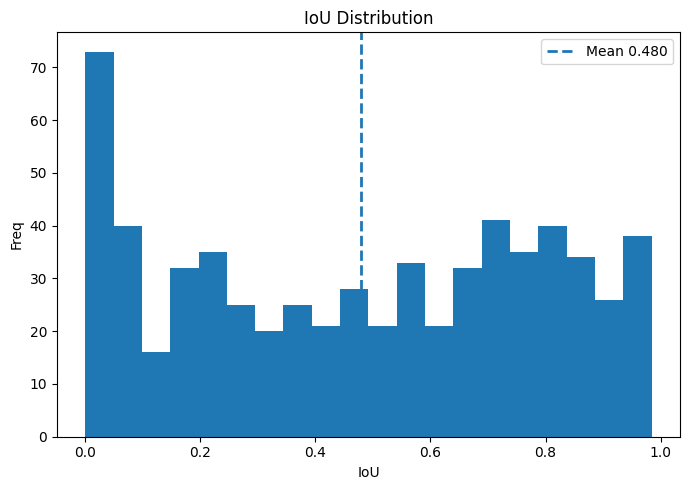

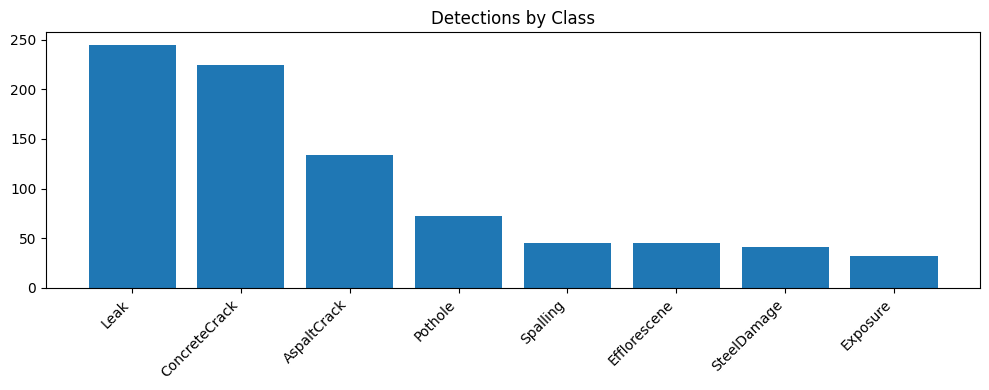

YOLO + SAM2 추론 결과 요약
- 전체 테스트 이미지: 898
- 처리된 이미지: 898
- 총 검출 박스: 838

[클래스별 검출 통계]
- Leak                :  245개 (29.2%)
- ConcreteCrack       :  224개 (26.7%)
- AspaltCrack         :  134개 (16.0%)
- Pothole             :   72개 (8.6%)
- Spalling            :   45개 (5.4%)
- Efflorescene        :   45개 (5.4%)
- SteelDamage         :   41개 (4.9%)
- Exposure            :   32개 (3.8%)

[IoU 평가]
- 평균: 0.4800
- 중앙값: 0.5009
- 표준편차: 0.3115
- 최소/최대: 0.0001 / 0.9844
- N: 636

[모델 설정]
- conf: 0.25 | iou: 0.5 | img_size: 512

[출력 경로]
- 결과 이미지: /content/predictions_yolo11s_sam2_100

🎉 모든 작업 완료!

📂 주요 결과물:
   1. 데이터셋: /content/drive/MyDrive/AICV_proj2/교량외관점검데이터/RESULT/datasets//
   2. 최적 모델: /content/best_yolo11s_sam.pt
   3. 학습 결과: yolo11n+sam/experiment/
   4. YOLO+SAM2 추론 결과: /content/predictions_yolo11s_sam2_100/


In [ ]:
import matplotlib.pyplot as plt
output_folder = "/content/predictions_yolo11s_sam2_100"
run_yolo_sam2_inference(
    yolo_model = best_model,
    test_image_paths=test_images,
    dataset_root=dataset_root,
    output_folder=output_folder,
    id_to_class_name=id_to_class_name,
    conf_threshold=0.25,
    iou_threshold=0.5,
    img_size=512,
    device=device
)

print("\n" + "=" * 60)
print("🎉 모든 작업 완료!")
print("=" * 60)
print(f"\n📂 주요 결과물:")
print(f"   1. 데이터셋: {dataset_root}/")
print(f"   2. 최적 모델: {best_model_path}")
print(f"   3. 학습 결과: {args.project}/{args.name}/")
print(f"   4. YOLO+SAM2 추론 결과: {output_folder}/")

# 13. Google Drive 마운트 및 백업

In [ ]:
print("\n" + "=" * 60)
print("Google Drive 백업")
print("=" * 60)

from google.colab import drive
import shutil
from datetime import datetime

# 백업 디렉토리 생성
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_root = f"/content/drive/MyDrive/YOLO11_Backup_{timestamp}"
os.makedirs(backup_root, exist_ok=True)

print(f"\n📁 백업 디렉토리: {backup_root}")


Google Drive 백업

📁 백업 디렉토리: /content/drive/MyDrive/YOLO11_Backup_20251031_070019


In [ ]:
# ========================================
# 1. 학습 결과 백업
# ========================================
print("\n" + "=" * 60)
print("1️⃣ 학습 결과 백업")
print("=" * 60)

source_project = f"{args.project}/{args.name}"
dest_project = f"{backup_root}/training_results"

if os.path.exists(source_project):
    print(f"📦 복사 중: {source_project}")
    shutil.copytree(source_project, dest_project, dirs_exist_ok=True)
    print(f"✅ 저장 완료: {dest_project}")

    # 주요 파일 확인
    important_files = [
        'weights/best.pt',
        'weights/last.pt',
        'results.png',
        'confusion_matrix.png',
        'results.csv'
    ]

    print("\n주요 파일 확인:")
    for file in important_files:
        file_path = os.path.join(dest_project, file)
        if os.path.exists(file_path):
            size = os.path.getsize(file_path) / (1024**2)  # MB
            print(f"  ✓ {file}: {size:.2f} MB")
        else:
            print(f"  ✗ {file}: 없음")
else:
    print(f"⚠️  학습 결과를 찾을 수 없습니다: {source_project}")

# ========================================
# 2. 추론 결과 백업 (있는 경우)
# ========================================
print("\n" + "=" * 60)
print("3️⃣ 추론 결과 백업")
print("=" * 60)

prediction_source = f"{args.project}/{args.name}/predictions"
prediction_dest = f"{backup_root}/predictions"

if os.path.exists(prediction_source):
    print(f"📦 복사 중: {prediction_source}")
    shutil.copytree(prediction_source, prediction_dest, dirs_exist_ok=True)
    print(f"✅ 저장 완료: {prediction_dest}")
else:
    print(f"⚠️  추론 결과가 없습니다")

# ========================================
# 3. 학습 설정 저장
# ========================================
print("\n" + "=" * 60)
print("5️⃣ 학습 설정 저장")
print("=" * 60)

config_file = f"{backup_root}/training_config.txt"
with open(config_file, 'w', encoding='utf-8') as f:
    f.write("=" * 60 + "\n")
    f.write("YOLOv8 학습 설정\n")
    f.write("=" * 60 + "\n\n")

    f.write(f"생성 시간: {timestamp}\n\n")

    f.write("학습 파라미터:\n")
    f.write(f"  - 모델: yolov8n-seg.pt\n")
    f.write(f"  - Epochs: {args.epoch}\n")
    f.write(f"  - Batch size: 16\n")
    f.write(f"  - Image size: 512\n")
    f.write(f"  - Device: {device}\n")
    f.write(f"  - Optimizer: auto (AdamW)\n")
    f.write(f"  - Patience: 100\n\n")

    f.write("프로젝트 정보:\n")
    f.write(f"  - Project: {args.project}\n")
    f.write(f"  - Name: {args.name}\n")
    f.write(f"  - Config: {args.config}\n\n")

print(f"✅ 학습 설정 저장 완료: training_config.txt")



1️⃣ 학습 결과 백업
📦 복사 중: yolo11n+sam/experiment
✅ 저장 완료: /content/drive/MyDrive/YOLO11_Backup_20251031_070019/training_results

주요 파일 확인:
  ✓ weights/best.pt: 5.21 MB
  ✓ weights/last.pt: 5.21 MB
  ✓ results.png: 0.27 MB
  ✓ confusion_matrix.png: 0.22 MB
  ✓ results.csv: 0.01 MB

3️⃣ 추론 결과 백업
📦 복사 중: yolo11n+sam/experiment/predictions
✅ 저장 완료: /content/drive/MyDrive/YOLO11_Backup_20251031_070019/predictions

5️⃣ 학습 설정 저장
✅ 학습 설정 저장 완료: training_config.txt


In [ ]:
# ========================================
# 6. README 생성
# ========================================
print("\n" + "=" * 60)
print("6️⃣ README 생성")
print("=" * 60)

readme_file = f"{backup_root}/README.md"
with open(readme_file, 'w', encoding='utf-8') as f:
    f.write("# YOLOv8 Segmentation 학습 결과\n\n")
    f.write(f"생성 일시: {timestamp}\n\n")

    f.write("## 📁 디렉토리 구조\n\n")
    f.write("```\n")
    f.write("YOLOv8_Backup_{timestamp}/\n")
    f.write("├── training_results/          # 학습 결과\n")
    f.write("│   ├── weights/\n")
    f.write("│   │   ├── best.pt           # 최적 모델\n")
    f.write("│   │   └── last.pt           # 마지막 모델\n")
    f.write("│   ├── results.png           # 학습 곡선\n")
    f.write("│   ├── confusion_matrix.png  # Confusion Matrix\n")
    f.write("│   └── results.csv           # 상세 결과\n")
    f.write("├── dataset_info/              # 데이터셋 정보\n")
    f.write("│   ├── dataset.yaml          # YAML 설정\n")
    f.write("│   ├── image_to_subdir.pkl   # 매핑 정보\n")
    f.write("│   └── dataset_statistics.txt # 통계\n")
    f.write("├── predictions/               # 추론 결과 (있는 경우)\n")
    f.write("├── samples/                   # 샘플 데이터\n")
    f.write("│   ├── train/\n")
    f.write("│   ├── val/\n")
    f.write("│   └── test/\n")
    f.write("├── training_config.txt        # 학습 설정\n")
    f.write("└── README.md                  # 이 파일\n")
    f.write("```\n\n")

    f.write("## 📊 데이터셋 정보\n\n")
    for split in ['train', 'val', 'test']:
        img_count = len([f for f in os.listdir(f"{dataset_root}/images/{split}") if f.endswith('.jpg')])
        label_count = len([f for f in os.listdir(f"{dataset_root}/labels/{split}") if f.endswith('.txt')])
        match_rate = (label_count / img_count * 100) if img_count > 0 else 0
        f.write(f"- **{split.capitalize()}**: {img_count}개 이미지, {label_count}개 라벨 ({match_rate:.1f}%)\n")

    f.write("\n## 🎯 클래스 정보\n\n")
    f.write("| ID | 클래스명 |\n")
    f.write("|:--:|:--------|\n")
    for name, cid in sorted(class_name_to_number.items(), key=lambda x: x[1]):
        f.write(f"| {cid} | {name} |\n")

    f.write("\n## 🚀 학습 설정\n\n")
    f.write(f"- 모델: YOLOv8n-seg\n")
    f.write(f"- Epochs: {args.epoch}\n")
    f.write(f"- Batch size: 16\n")
    f.write(f"- Image size: 512×512\n")
    f.write(f"- Device: {device}\n")

    f.write("\n## 📝 재현 방법\n\n")
    f.write("### 1. 모델 로드\n")
    f.write("```python\n")
    f.write("from ultralytics import YOLO\n\n")
    f.write("# 최적 모델 로드\n")
    f.write("model = YOLO('training_results/weights/best.pt')\n")
    f.write("```\n\n")

    f.write("### 2. 추론\n")
    f.write("```python\n")
    f.write("# 이미지 추론\n")
    f.write("results = model.predict(\n")
    f.write("    source='path/to/image.jpg',\n")
    f.write("    imgsz=512,\n")
    f.write("    conf=0.25,\n")
    f.write("    device='cuda'\n")
    f.write(")\n")
    f.write("```\n\n")

    f.write("### 3. 추가 학습 (Fine-tuning)\n")
    f.write("```python\n")
    f.write("# 학습 재개\n")
    f.write("model = YOLO('training_results/weights/best.pt')\n")
    f.write("model.train(\n")
    f.write("    data='dataset_info/dataset.yaml',\n")
    f.write("    epochs=50,\n")
    f.write("    resume=True\n")
    f.write(")\n")
    f.write("```\n\n")

    f.write("## 📧 문의\n\n")
    f.write("이 모델에 대한 문의사항은 프로젝트 담당자에게 연락하세요.\n")

print(f"✅ README 생성 완료: README.md")

# ========================================
# 7. 백업 요약
# ========================================
print("\n" + "=" * 60)
print("📊 백업 요약")
print("=" * 60)

def get_dir_size(path):
    """디렉토리 크기 계산 (MB)"""
    total = 0
    try:
        for dirpath, dirnames, filenames in os.walk(path):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                if os.path.exists(fp):
                    total += os.path.getsize(fp)
    except:
        pass
    return total / (1024**2)

print(f"\n📁 백업 위치: {backup_root}\n")

backup_items = [
    ('training_results', '학습 결과'),
    ('dataset_info', '데이터셋 정보'),
    ('predictions', '추론 결과'),
    ('samples', '샘플 데이터')
]

total_size = 0
for item, desc in backup_items:
    item_path = f"{backup_root}/{item}"
    if os.path.exists(item_path):
        size = get_dir_size(item_path)
        total_size += size
        print(f"  ✓ {desc:15s}: {size:7.2f} MB")
    else:
        print(f"  - {desc:15s}: 없음")

# 설정 파일 크기
config_size = (os.path.getsize(config_file) + os.path.getsize(readme_file)) / (1024**2)
total_size += config_size

print(f"  ✓ {'설정 파일':15s}: {config_size:7.2f} MB")
print(f"  {'='*15}   {'='*7}")
print(f"  {'총 크기':15s}: {total_size:7.2f} MB")

print("\n" + "=" * 60)
print("✅ 모든 백업 완료!")
print("=" * 60)
print(f"\n📂 Google Drive에서 확인:")
print(f"   {backup_root.replace('/content/drive/MyDrive/', '')}")
print("\n💡 Tip: 백업된 폴더를 압축하면 더 쉽게 공유할 수 있습니다.")


6️⃣ README 생성
✅ README 생성 완료: README.md

📊 백업 요약

📁 백업 위치: /content/drive/MyDrive/YOLO11_Backup_20251031_070019

  ✓ 학습 결과          :   20.85 MB
  - 데이터셋 정보        : 없음
  ✓ 추론 결과          :    1.02 MB
  - 샘플 데이터         : 없음
  ✓ 설정 파일          :    0.00 MB
  ===============   =======
  총 크기           :   21.87 MB

✅ 모든 백업 완료!

📂 Google Drive에서 확인:
   YOLO11_Backup_20251031_070019

💡 Tip: 백업된 폴더를 압축하면 더 쉽게 공유할 수 있습니다.
